# Testing Mouth Open/Close Detection

In [111]:
from commonfunctions import *
import math
from skimage import filters
from skimage import data
from skimage.color import rgb2gray

import dlib

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(768, 512, 3)


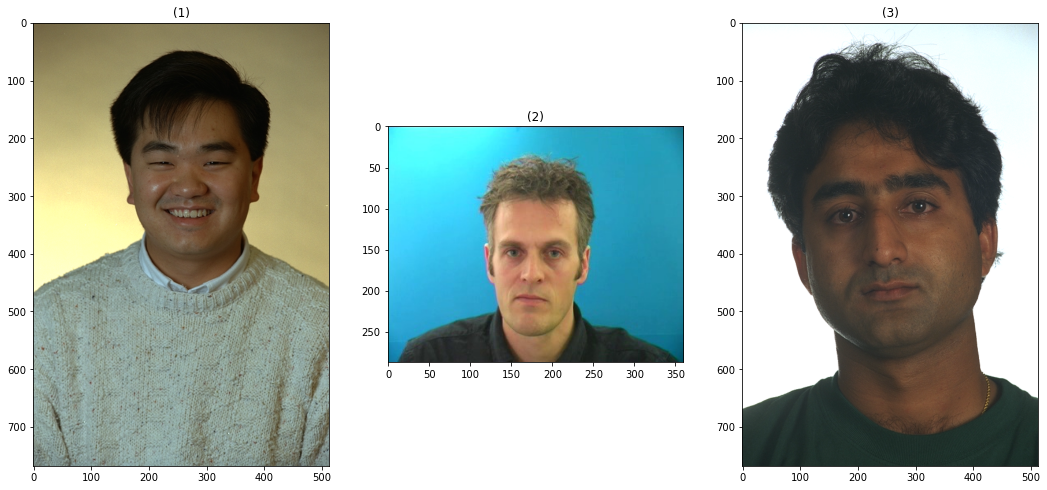

In [120]:
img_PPM=io.imread("00616_940928_fb.ppm")
print(img_PPM.shape)
img_open = io.imread('00110_931230_fa.ppm')
# img_open=img_open[:,:,:3]
img_close = io.imread('frame69.jpg')
show_images([img_open, img_close,img_PPM])

In [121]:
def detectMouth(img):
    # detect face:
    detector = dlib.get_frontal_face_detector()
    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))

    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))

    face = img[d.top():d.bottom(), d.left():d.right()]
    dimensions_face=face.shape
    mouth = face[int(dimensions_face[0]/2+(0.05*(d.bottom()-d.top()))):,:,:]


    quarter_face=mouth.shape[1]//4
    mouth= mouth[:,quarter_face:quarter_face*3,:]

    dimensions_mouth=mouth.shape

    io.imshow(face)
    io.imshow(mouth)
    io.show()
    return mouth , dimensions_mouth

In [122]:
def selectLipRegion(mouth, dimensions_mouth):
    R = mouth[:,:,0]
    G = mouth[:,:,1]

    print(mouth.shape)
    # calculate chromatism
    chromatism = 2 * np.arctan((R-G)/R) / np.pi

    io.imshow(chromatism)
    io.show()
    chromatism = chromatism.reshape(-1,1)

    sorted_chromatism = -np.sort(-chromatism,axis=None,)

    chromatism_mouth_perc = int(chromatism.shape[0] * 0.15)
    print("15 percent :",chromatism_mouth_perc)
    chromatsim_largest_twenty=sorted_chromatism[0:chromatism_mouth_perc]


    chromatism = chromatism.reshape(dimensions_mouth[0],dimensions_mouth[1])
    io.imshow(chromatism)
    io.show()

    #print(chromatism in chromatsim_largest_twenty)
    new_img = np.zeros(dimensions_mouth)

    for i in range(0,dimensions_mouth[0]):
        for j in range(0,dimensions_mouth[1]):
            if chromatism[i,j] in chromatsim_largest_twenty:
                new_img[i,j]=255
            else:
                new_img[i,j]=0

    #new_img = chromatism[x for x in chromatsim_largest_twenty]
    io.imshow(new_img)
    io.show()

    return new_img


In [123]:
def contourIntersect(contour1, contour2):
    intersection = cv2.pointPolygonTest(contour1,(int(contour2[0][0][0]),int(contour2[0][0][1])),False)
    return intersection

In [124]:
def getROI(mouth):

    #showing contours
    temp = np.zeros_like(mouth)
    #one connected component or 2 connected component
    connected = True  

    # get 2 largest contours 
    largest_two_cnts=contours[0:2]  
    print(cv2.contourArea(largest_two_cnts[0]))
    cv2.drawContours(temp, largest_two_cnts, -1, (255,0,0), 1) #draw all contours
    show_images([temp],["2 largest cnts"])


    #if 2 components are nested , inside = 1 , else , components are not connected
    inside = contourIntersect(largest_two_cnts[0],largest_two_cnts[1])   

    if inside>0:
        connected=True
    else:
        connected=False

    if connected: # if connected , draw bounding rect for largest (outer contour)
        x,y,w,h = cv2.boundingRect(largest_two_cnts[0])
        cv2.rectangle(temp,(x,y),(x+w,y+h),(255,255,255),1)
        print("connected ",x,y,w,h)
        ROI = mouth_open[max(2,y-int(0.10*mouth.shape[0])):min(int(y+h+int(0.10*mouth.shape[0])),mouth.shape[0]),max(2,x-int(0.2*mouth.shape[1])):min(mouth.shape[1],x+w+int(0.2*mouth.shape[1])),:]
    else:   #else , draw bounding rect for both region
        x1,y1,w1,h1 = cv2.boundingRect(largest_two_cnts[0])     
        cv2.rectangle(temp,(x1,y1),(x1+w1,y1+h1),(255,255,255),1)

        x2,y2,w2,h2 = cv2.boundingRect(largest_two_cnts[1])
        cv2.rectangle(temp,(x2,y2),(x2+w2,y2+h2),(255,255,255),1)

        print("area difference : ",cv2.contourArea(largest_two_cnts[0])-cv2.contourArea(largest_two_cnts[1]))           
        if cv2.contourArea(largest_two_cnts[0])-cv2.contourArea(largest_two_cnts[1]) >500:      #if the size of second largest is negligible in comparison to first , discard it
            print("not connected ",x1,y1,w1,h1)
            ROI = mouth_open[max(2,y1-int(0.10*mouth.shape[0])):min(mouth.shape[0],y1+h1+int(0.10*mouth.shape[0])),max(2,x1-int(0.2*mouth.shape[1])):min(mouth.shape[1],x1+w1+int(0.2*mouth.shape[1])),:]
        else:
            minx=min([x1,x2])               #get the minx maxx miny maxy of the 2 bounding rectangles combined
            maxx=max([x1+w1,x2+w2])
            miny=min([y1,y2])
            maxy=max([y1+h1,y2+h2])
            print("not connected ",miny,maxy,minx,maxx)
            ROI = mouth_open[max(2,miny-int(0.10*mouth.shape[0])):min(mouth.shape[0],maxy+int(0.10*mouth.shape[0])),max(2,minx-int(0.2*mouth.shape[1])):min(mouth.shape[1],maxx+int(0.2*mouth.shape[1])),:]         #retrieve ROI

    return ROI

Number of faces detected: 1
Detection 0: Left: 167 Top: 167 Right: 390 Bottom: 390


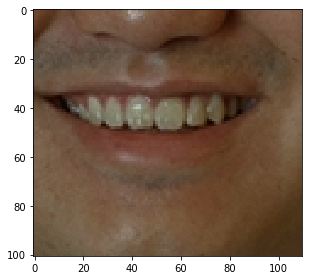

(101, 110, 3)


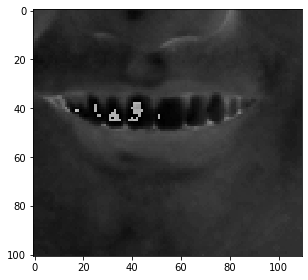

15 percent : 1666


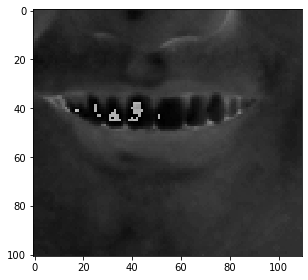

C:\Users\myass\anaconda3\envs\gp\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


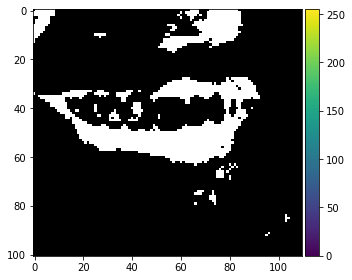

<class 'numpy.uint8'>


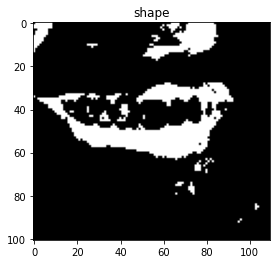

(101, 110)


In [125]:
mouth_open , dim_open = detectMouth(img_open)
mouth = selectLipRegion(mouth_open, dim_open)
mouth = np.uint8( rgb2gray(mouth) *255 ) 

print(type(mouth[0][0]))

show_images([mouth],["shape"])
print(mouth.shape)

#simulate 2 regions
# mouth[20:22,:]=0
# show_images([mouth],["2 regions simulation"])
#############################################

contours, hierarchy = cv2.findContours(mouth, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

########################################################################################################################
# mouth_close , dim_close = detectMouth(img_close)
# selectLipRegion(mouth_close, dim_close)


In [126]:
contours=sorted(contours,key=lambda x: cv2.contourArea(x),reverse=True) #sorted contours descendingly according to area

1040.0


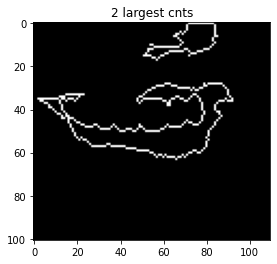

area difference :  800.0
not connected  2 28 91 36


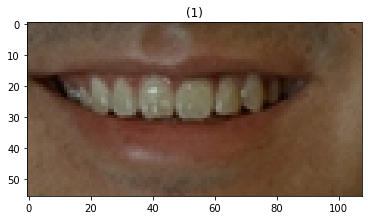

In [127]:
# cv2.drawContours(temp, contours, 0, (255,0,0), 1) #draw all contours
# show_images([temp])

ROI = getROI(mouth)

show_images([ROI])


### Challenges:
1. how to detect whether lips is connected or not -> when to select one biggest contour / 2 biggest contours?

# Find mouth contours


(56, 108, 3)
(6048, 1)


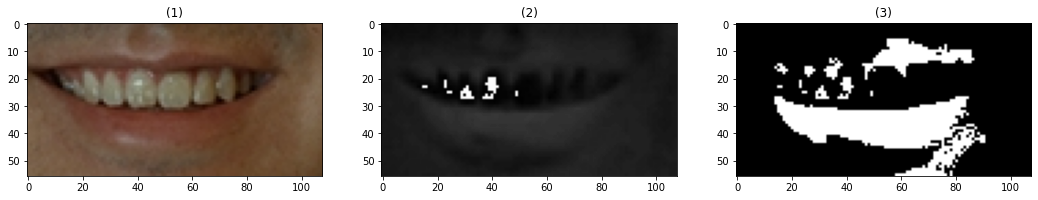

In [130]:
#calculate threshold T for segmentation

print(ROI.shape)

#calculate R - G 
red_minus_green = ROI[:,:,0]-ROI[:,:,1]
red_minus_green_vector = red_minus_green.reshape(-1,1)

print(red_minus_green_vector.shape)

top_20 = int(0.2*red_minus_green_vector.shape[0])

red_minus_green_sorted = sorted(red_minus_green_vector,reverse=True)
red_minus_green_top_20 = red_minus_green_sorted[0:top_20]

red_minus_green = red_minus_green.reshape(ROI.shape[0],ROI.shape[1])

new_img = red_minus_green == red_minus_green_top_20[0]

for i in range(1,top_20):
    new_img |= red_minus_green == red_minus_green_top_20[i] 

new_img = np.uint8(new_img*255)
new_img = closing(new_img,selem=square(5))

show_images([ROI,red_minus_green,new_img])
